In [1]:
# ============================================
# 0) INSTALL DEPENDENCIES
# ============================================
!pip -q install kaggle langchain-community replicate pandas scikit-learn tqdm textstat sentence-transformers matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [2]:
# 1) IMPORTS & BASIC SETUP
# ============================================
import os, json, time, re, random, math
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import textstat
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Colab helpers (optional)
try:
    from google.colab import files, userdata
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    userdata = None


In [5]:
# 2) TOKENS & KAGGLE SETUP
# ============================================
print("==[KAGGLE & REPLICATE SETUP]==")
...


==[KAGGLE & REPLICATE SETUP]==


Ellipsis

In [7]:
#  LOAD CSV FILE
# ============================================
print("==[LOAD CSV IMDB]==")

# Masukkan path CSV kamu
csv_path = "IMDB Dataset.csv"  # Pastikan file sudah diupload di Colab
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File {csv_path} tidak ditemukan. Upload dulu ke Colab.")

import pandas as pd
df = pd.read_csv(csv_path)

print(f"Dataset berhasil dimuat: {len(df)} baris")
print(df.head())

==[LOAD CSV IMDB]==
Dataset berhasil dimuat: 50000 baris
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [8]:
# --- B) Replicate token ---
# 1) Utamakan dari Colab userdata
api_token = None
if userdata is not None:
    try:
        api_token = userdata.get('api_token')
    except Exception:
        api_token = None

# 2) Fallback manual: isi di sini jika belum set di userdata
if not api_token:
    api_token = ""  # <- opsional: tempel token replicate kamu di sini jika tidak pakai userdata

if not api_token:
    raise RuntimeError(
        "REPLICATE API token belum di-set.\n"
        "Opsi A (disarankan): jalankan sekali -> from google.colab import userdata; userdata.set('api_token','TOKEN_MU')\n"
        "Opsi B: isi variabel api_token di atas."
    )

os.environ["REPLICATE_API_TOKEN"] = api_token

In [10]:
# 3) LOAD DATASET IMDB DARI CSV LOKAL
# ============================================
print("\n==[LOAD IMDB DATASET]==")

import os
import pandas as pd

CSV_PATH = "IMDB Dataset.csv"  # pastikan sudah diupload ke workspace
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File {CSV_PATH} tidak ditemukan. Upload dulu ke notebook.")

df = pd.read_csv(CSV_PATH)
print(f"Dataset shape: {df.shape}")
df.head()



==[LOAD IMDB DATASET]==
Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
# 4) CLEANING & SAMPLING
# ============================================
# Mapping sentiment ke label standar
df['sentiment'] = df['sentiment'].str.lower().map({'positive':'Positive','negative':'Negative'})

# (Opsional) ambil subset untuk dev/test biar hemat token:
N_SAMPLES = 300   # atur sesuai budget token; 300 s/d 1000 biasanya cukup untuk evaluasi kuat
df_sample = df.sample(N_SAMPLES, random_state=42).reset_index(drop=True)
print(f"Sample shape: {df_sample.shape}")

Sample shape: (300, 2)


In [12]:
# 5) MODEL: Replicate + Granite 3.2 8B Instruct
# ============================================
from langchain_community.llms import Replicate

GRANITE_MODEL_ID = "ibm-granite/granite-3.2-8b-instruct"

llm = Replicate(
    model=GRANITE_MODEL_ID,
    replicate_api_token=api_token,
)


In [13]:
# 6) PROMPT DESIGN (JSON-STRICT, ROBUST)
# ============================================
SYSTEM_INSTRUCTIONS = """
You are a world-class sentiment classification expert.
Classify each movie review as exactly one of: "Positive", "Negative", or "Mixed".
Return STRICT JSON with the following schema:
{
  "label": "Positive|Negative|Mixed",
  "confidence": float between 0 and 1,
  "explanation": "one or two clear sentences explaining the reasoning, without quotes"
}
Rules:
- Output ONLY the JSON object, no extra text, no markdown.
- If the review clearly expresses praise/approval -> Positive.
- If the review clearly expresses criticism/disapproval -> Negative.
- Use "Mixed" only if the review convincingly includes both strong pros and cons.
- Be concise, neutral, and avoid emojis or special characters.
"""

def build_prompt(review_text):
    # Kita mendorong output JSON ketat dan batasi halusinasi
    return f"""{SYSTEM_INSTRUCTIONS}

Review:
\"\"\"{review_text.strip()}\"
\"\"\"
Return JSON now:"""


In [14]:
# 7) INFERENCE HELPER (RETRY + JSON PARSER)
# ============================================
def parse_json_strict(s):
    # Ambil blok JSON pertama yang valid, kalau ada noise
    try:
        # langsung coba json.loads
        return json.loads(s)
    except:
        pass
    # fallback: regex cari {...}
    m = re.search(r'\{.*\}', s, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(0))
        except:
            pass
    # upaya perbaikan karakter kutip
    s2 = s.replace("“","\"").replace("”","\"").replace("’","'").replace("\n"," ")
    try:
        return json.loads(s2)
    except:
        pass
    raise ValueError("Gagal parse JSON dari model output.")

def classify_with_retry(review_text, max_retries=3, sleep_base=2.0):
    prompt = build_prompt(review_text)
    for attempt in range(1, max_retries+1):
        try:
            out = llm.invoke(prompt)
            data = parse_json_strict(out)
            # normalisasi
            label = data.get("label","").strip()
            if label not in ["Positive","Negative","Mixed"]:
                # coba paksa ke salah satu
                l = label.lower()
                if "pos" in l: label = "Positive"
                elif "neg" in l: label = "Negative"
                else: label = "Mixed"
                data["label"] = label
            # bound confidence
            conf = data.get("confidence", 0.5)
            try:
                conf = float(conf)
            except:
                conf = 0.5
            conf = max(0.0, min(1.0, conf))
            data["confidence"] = conf
            # explanation fallback
            if not data.get("explanation"):
                data["explanation"] = ""
            return data
        except Exception as e:
            if attempt == max_retries:
                # fallback minimal jika tetap gagal
                return {"label":"Mixed","confidence":0.0,"explanation":f"parse_error: {str(e)[:60]}"}
            time.sleep(sleep_base * attempt)

In [15]:
# 8) RUN INFERENCE + CACHING (CSV)
# ============================================
CACHE_PATH = "./imdb_granite_predictions.csv"

if os.path.exists(CACHE_PATH):
    preds_df = pd.read_csv(CACHE_PATH)
    print(f"Memuat cache prediksi: {preds_df.shape}")
else:
    records = []
    print("Menjalankan inference Granite (dengan caching). Ini memerlukan waktu & token.")
    for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        review = row['review']
        gt = row['sentiment']  # Positive / Negative

        result = classify_with_retry(review)
        records.append({
            "idx": i,
            "review": review,
            "ground_truth": gt,
            "pred_label": result.get("label","Mixed"),
            "confidence": result.get("confidence", 0.0),
            "explanation": result.get("explanation",""),
        })

    preds_df = pd.DataFrame(records)
    preds_df.to_csv(CACHE_PATH, index=False)
    print(f"Prediksi disimpan ke {CACHE_PATH}")

preds_df.head()

Menjalankan inference Granite (dengan caching). Ini memerlukan waktu & token.


100%|██████████| 300/300 [06:27<00:00,  1.29s/it]

Prediksi disimpan ke ./imdb_granite_predictions.csv


,idx,review,ground_truth,pred_label,confidence,explanation
0,0,I really liked this Summerslam due to the look...,Positive,Mixed,0.85,The review expresses both positive and negativ...
1,1,Not many television shows appeal to quite as m...,Positive,Positive,0.95,The review expresses strong admiration for Far...
2,2,The film quickly gets to a major chase scene w...,Negative,Mixed,0.85,The review expresses both positive and negativ...
3,3,Jane Austen would definitely approve of this o...,Positive,Positive,1.00,The review expresses strong praise for the fil...
4,4,Expectations were somewhat high for me when I ...,Negative,Negative,0.95,The review expresses strong criticism towards ...


/tmp/ipython-input-1504036471.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(preds_df, x='confidence', y='pred_label', inner='stick', palette='Dark2')


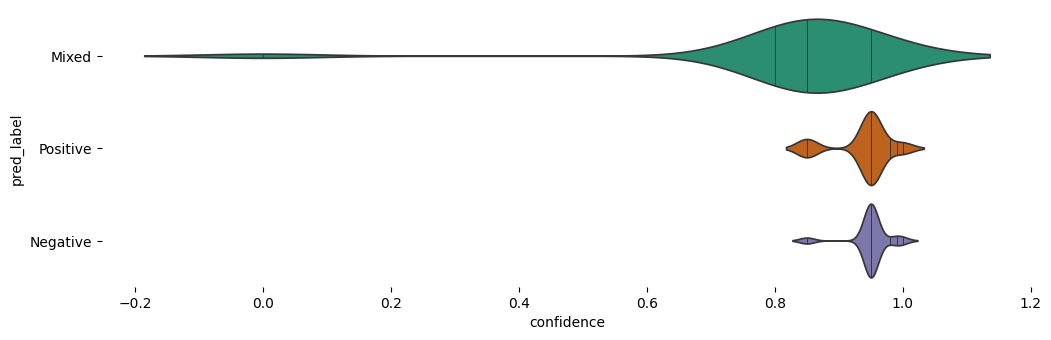

In [26]:
# @title pred_label vs confidence

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(preds_df['pred_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(preds_df, x='confidence', y='pred_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

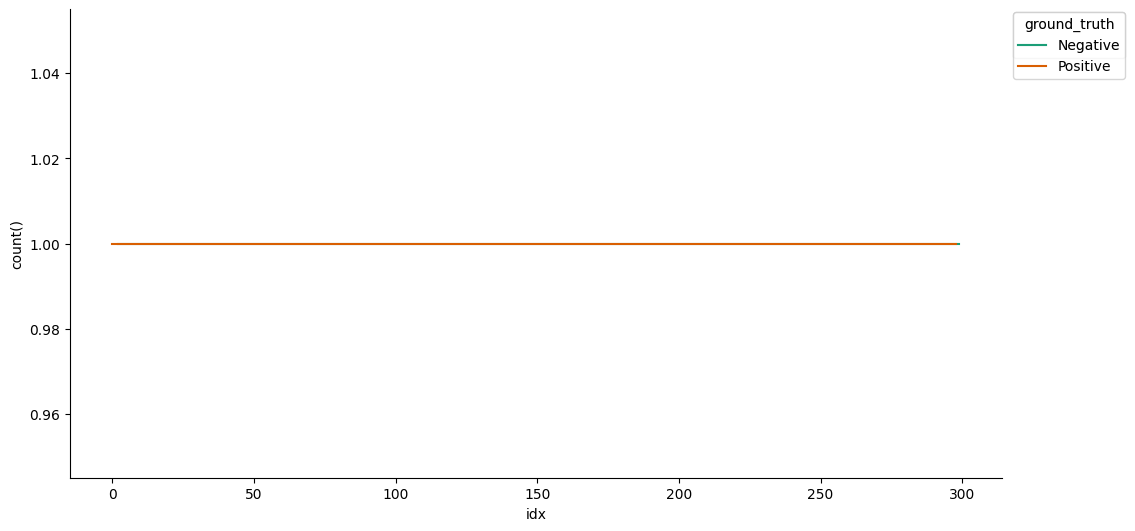

In [25]:
# @title idx vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['idx']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'idx'}, axis=1)
              .sort_values('idx', ascending=True))
  xs = counted['idx']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = preds_df.sort_values('idx', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ground_truth')):
  _plot_series(series, series_name, i)
  fig.legend(title='ground_truth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('count()')

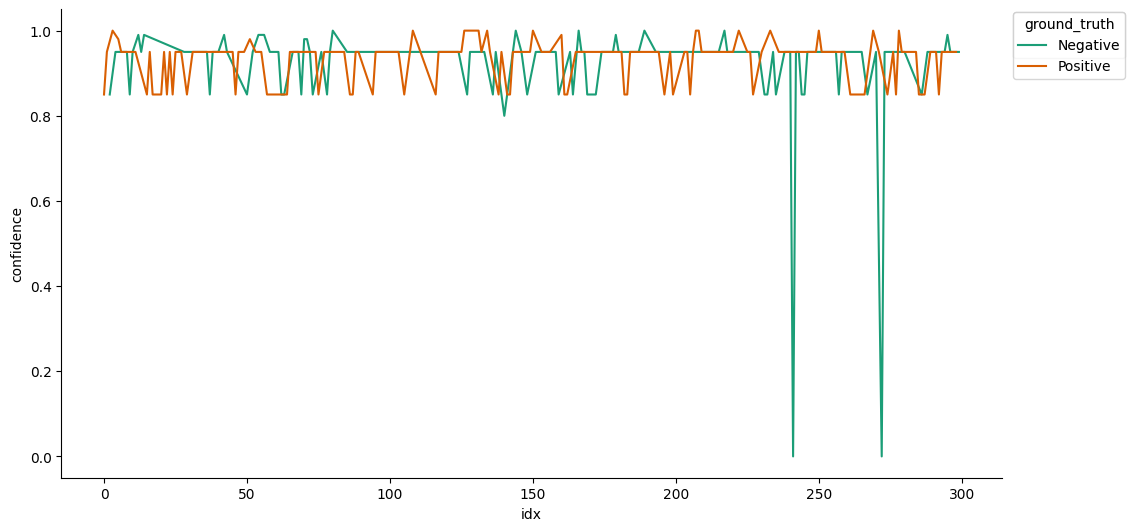

In [24]:
# @title idx vs confidence

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['idx']
  ys = series['confidence']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = preds_df.sort_values('idx', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ground_truth')):
  _plot_series(series, series_name, i)
  fig.legend(title='ground_truth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('confidence')

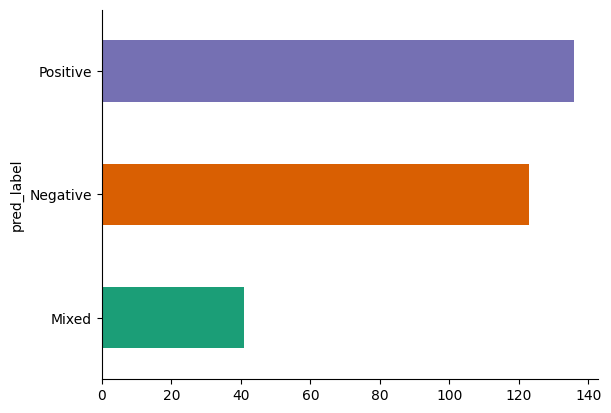

In [23]:
# @title pred_label

from matplotlib import pyplot as plt
import seaborn as sns
preds_df.groupby('pred_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

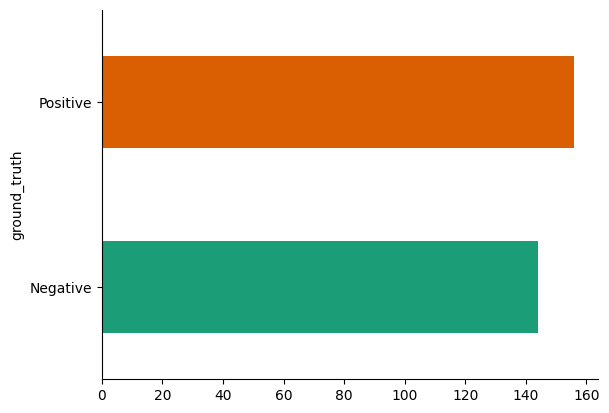

In [22]:
# @title ground_truth

from matplotlib import pyplot as plt
import seaborn as sns
preds_df.groupby('ground_truth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

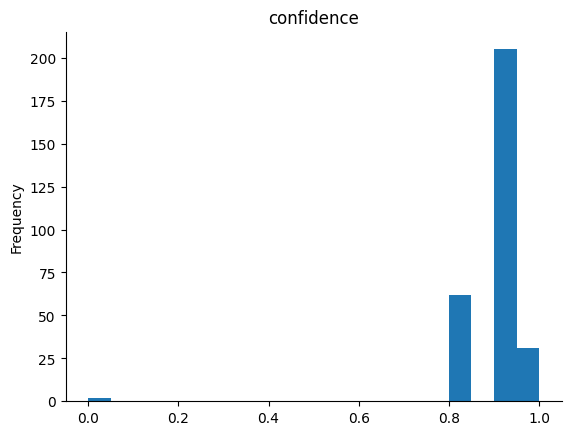

In [21]:
# @title confidence

from matplotlib import pyplot as plt
preds_df['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

/tmp/ipython-input-3146772443.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(preds_df, x='idx', y='ground_truth', inner='stick', palette='Dark2')


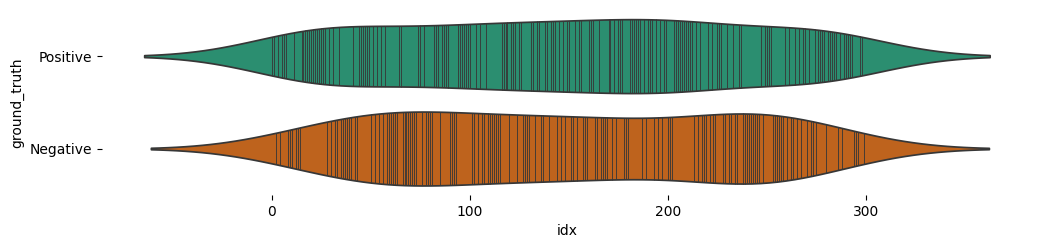

In [20]:
# @title ground_truth vs idx

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(preds_df['ground_truth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(preds_df, x='idx', y='ground_truth', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

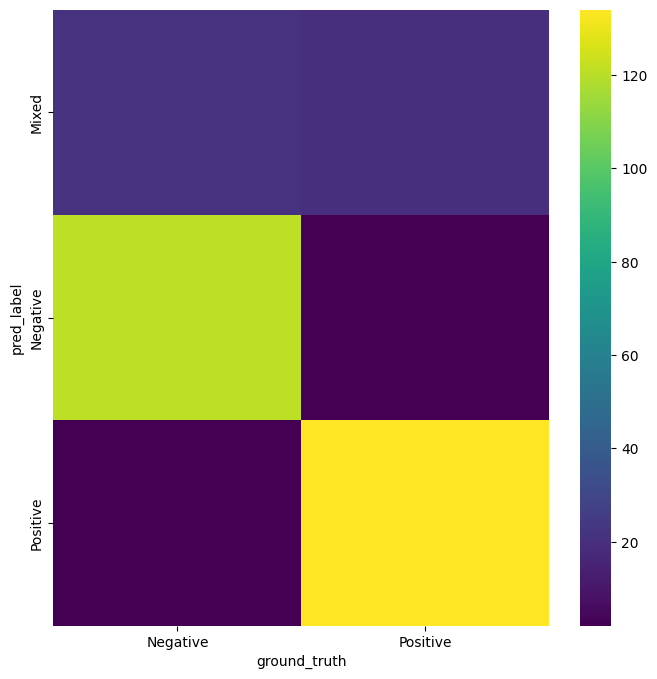

In [19]:
# @title ground_truth vs pred_label

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['pred_label'].value_counts()
    for x_label, grp in preds_df.groupby('ground_truth')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ground_truth')
_ = plt.ylabel('pred_label')

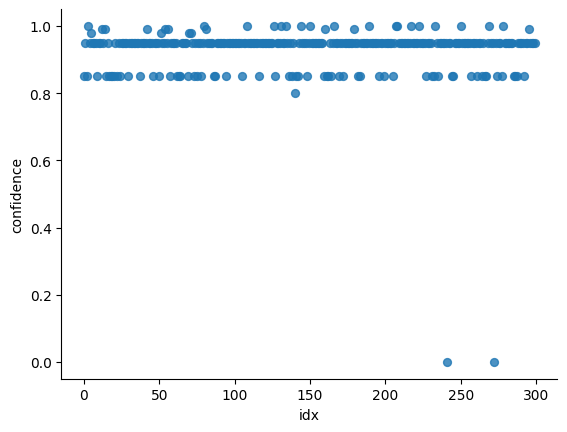

In [18]:
# @title idx vs confidence

from matplotlib import pyplot as plt
preds_df.plot(kind='scatter', x='idx', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

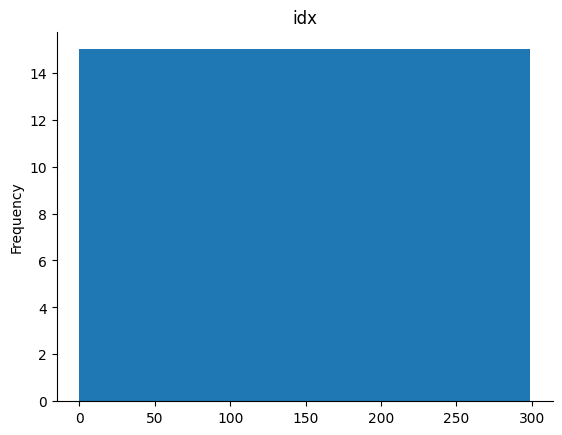

In [17]:
# @title idx

from matplotlib import pyplot as plt
preds_df['idx'].plot(kind='hist', bins=20, title='idx')
plt.gca().spines[['top', 'right',]].set_visible(False)


==[CLASSIFICATION METRICS]==
Accuracy : 0.8500
Macro P  : 0.9845
Macro R  : 0.8496
Macro F1 : 0.9121

==[CLASSIFICATION REPORT]==
              precision    recall  f1-score   support

       Mixed     0.0000    0.0000    0.0000         0
    Negative     0.9837    0.8403    0.9064       144
    Positive     0.9853    0.8590    0.9178       156

    accuracy                         0.8500       300
   macro avg     0.6563    0.5664    0.6081       300
weighted avg     0.9845    0.8500    0.9123       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


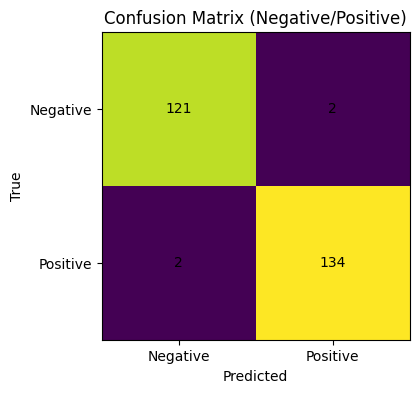

In [27]:
# 9) METRIK: ACCURACY, PRECISION, RECALL, F1
# ============================================
# Kita evaluasi hanya pada dua kelas ground truth (Positive/Negative).
# Jika model jawab "Mixed", kita anggap salah (atau bisa di-map ke label terdekat jika mau).
y_true = preds_df["ground_truth"].values
y_pred = preds_df["pred_label"].values

# Map Mixed -> Negative (opsi), atau jadikan salah. Di sini kita jadikan salah apa adanya.
# Jika ingin map Mixed ke kelas terdekat, bisa pakai heuristik dari explanation (tidak kita lakukan untuk fairness).
valid_mask = np.isin(y_true, ["Positive","Negative"])
y_true_eval = y_true[valid_mask]
y_pred_eval = y_pred[valid_mask]

acc = accuracy_score(y_true_eval, y_pred_eval)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_eval, y_pred_eval, labels=["Negative","Positive"], average='macro', zero_division=0)

print("\n==[CLASSIFICATION METRICS]==")
print(f"Accuracy : {acc:.4f}")
print(f"Macro P  : {prec:.4f}")
print(f"Macro R  : {rec:.4f}")
print(f"Macro F1 : {f1:.4f}\n")

print("==[CLASSIFICATION REPORT]==")
print(classification_report(y_true_eval, y_pred_eval, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_eval, y_pred_eval, labels=["Negative","Positive"])
fig = plt.figure(figsize=(4,4))
plt.title("Confusion Matrix (Negative/Positive)")
plt.imshow(cm, interpolation='nearest')
plt.xticks([0,1], ["Negative","Positive"])
plt.yticks([0,1], ["Negative","Positive"])
for (j,i),label in np.ndenumerate(cm):
    plt.text(i,j,label,ha='center',va='center')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [28]:
# 10) RELEVANCE & CLARITY
# Relevance: cosine similarity(review, explanation)
# Clarity: gabungan readability + kepadatan kalimat explanation
# ============================================
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def compute_relevance_clarity(row):
    review = str(row["review"])
    explanation = str(row["explanation"])

    # --- Relevance ---
    try:
        emb = embedder.encode([review, explanation])
        rel = float(cosine_similarity([emb[0]],[emb[1]])[0][0])
    except:
        rel = 0.0

    # --- Clarity ---
    # Pakai Flesch Reading Ease (semakin tinggi semakin mudah dibaca), normalisasi 0..1
    # FRE tipikal: 0..100+ ; kita skala: score/100 dibatasi [0,1]
    try:
        fre = textstat.flesch_reading_ease(explanation)
        fre = max(0.0, min(100.0, float(fre)))
        clarity_readability = fre / 100.0
    except:
        clarity_readability = 0.5

    # Tambah komponen struktur: penalti jika terlalu panjang/pendek
    n_words = len(explanation.split())
    if n_words == 0:
        clarity_len = 0.0
    else:
        # ideal 12-40 kata
        if n_words < 12:
            clarity_len = n_words / 12.0
        elif n_words > 40:
            clarity_len = max(0.0, 1.0 - (n_words-40)/60.0)  # turun perlahan
            clarity_len = max(0.0, min(1.0, clarity_len))
        else:
            clarity_len = 1.0

    clarity = 0.7*clarity_readability + 0.3*clarity_len
    return pd.Series({"relevance": rel, "clarity": clarity})

preds_df[["relevance","clarity"]] = preds_df.apply(compute_relevance_clarity, axis=1)

print("\n==[QUALITY METRICS]==")
print(f"Avg Relevance: {preds_df['relevance'].mean():.4f}")
print(f"Avg Clarity  : {preds_df['clarity'].mean():.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


==[QUALITY METRICS]==
Avg Relevance: 0.5279
Avg Clarity  : 0.4607


In [33]:
# 11) RINGKASAN FINAL + SAVE
# ============================================
summary = {
    "model": GRANITE_MODEL_ID,
    "n_samples": int(len(preds_df)),
    "accuracy": float(acc),
    "macro_precision": float(prec),
    "macro_recall": float(rec),
    "macro_f1": float(f1),
    "avg_relevance": float(preds_df['relevance'].mean()),
    "avg_clarity": float(preds_df['clarity'].mean()),
}

print("\n==[PROJECT SUMMARY]==")
print(json.dumps(summary, indent=2))

# Simpan hasil lengkap untuk laporan
OUT_CSV = "./imdb_granite_results_full.csv"
preds_df.to_csv(OUT_CSV, index=False)
print(f"\nHasil rinci disimpan ke: {OUT_CSV}")

from google.colab import files
files.download(OUT_CSV)



==[PROJECT SUMMARY]==
{
  "model": "ibm-granite/granite-3.2-8b-instruct",
  "n_samples": 300,
  "accuracy": 0.85,
  "macro_precision": 0.9845169775227165,
  "macro_recall": 0.8496260683760684,
  "macro_f1": 0.9120876301882921,
  "avg_relevance": 0.5278750361471126,
  "avg_clarity": 0.4607278303044684
}

Hasil rinci disimpan ke: ./imdb_granite_results_full.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# 12) SAMPEL HASIL ACak (untuk lampiran)
# ============================================
display_cols = ["review","ground_truth","pred_label","confidence","explanation","relevance","clarity"]
print("\n==[SAMPLE PREDICTIONS]==")
display(preds_df[display_cols].sample(5, random_state=7))


==[SAMPLE PREDICTIONS]==


,review,ground_truth,pred_label,confidence,explanation,relevance,clarity
254,The Thumb idea isn't such a winner the second ...,Negative,Mixed,0.95,The review presents a mix of positive and nega...,0.718176,0.410253
57,"A remake of the 1916 silent film, based on the...",Positive,Positive,0.85,"The review expresses admiration for the film, ...",0.369919,0.569395
150,"This movie is well made, it is beautiful and w...",Positive,Positive,1.00,The review expresses overwhelming praise for t...,0.631426,0.555570
66,There's a part of me that would like to give t...,Negative,Mixed,0.95,The review presents a mix of positive and nega...,0.655756,0.350955
114,I actually saw this movie in the theater back ...,Negative,Negative,0.95,The review expresses strong criticism of the m...,0.621686,0.547166
